In [169]:
import os
import torch
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from tqdm import trange
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report

In [146]:
class CNN1D(nn.Module):
    def __init__(self, number_of_categories):
        super(CNN1D, self).__init__()
        # convolution layer
        # in_channels must be the same as the number of subcarriers, out_channels can be any value
        self.conv1d = nn.Conv1d(in_channels=64, out_channels=40, kernel_size=3, stride=1)
        self.maxpool = nn.MaxPool1d(kernel_size=2)
        self.relu = nn.ReLU()

        # calculate the in_features
        self.fc1 = nn.Linear(in_features=40 * 19, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=number_of_categories)

    def forward(self, x):
        # input tensor size [batch_size, 64 (features), 40 (sequence length)]
        x = self.conv1d(x)
        # [batch_size, 64 (features), 40 (sequence length)]
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(-1, x.shape[1] * x.shape[2])  # Adjust the input size based on the output size after convolutions and pooling
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return x

In [147]:
class CSIDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.int)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [148]:
def importData():
    X_train, X_val, X_test, y_train, y_val, y_test = [], [], [], [], [], []
    for i in range(10):
        temp_train = np.load(f'../data/processed_data/{i}_table_train.npy')
        temp_val = np.load(f'../data/processed_data/{i}_table_val.npy')
        temp_test = np.load(f'../data/processed_data/{i}_table_test.npy')
        if i == 0:
            X_train = temp_train
            X_val = temp_val
            X_test = temp_test
            y_train = np.array([[i] for _ in range(X_train.shape[0])])
            y_val = np.array([[i] for _ in range(X_val.shape[0])])
            y_test = np.array([[i] for _ in range(X_test.shape[0])])
        else:
            X_train = np.append(X_train, temp_train, axis=0)
            X_val = np.append(X_val, temp_val, axis=0)
            X_test = np.append(X_test, temp_test, axis=0)
            y_train = np.append(y_train, np.array([[i] for _ in range(temp_train.shape[0])]), axis=0)
            y_val = np.append(y_val, np.array([[i] for _ in range(temp_val.shape[0])]), axis=0)
            y_test = np.append(y_test, np.array([[i] for _ in range(temp_test.shape[0])]), axis=0)
            
    return X_train, X_val, X_test, y_train, y_val, y_test

In [149]:
class RunningAverage:
    def __init__(self):
        self.steps = 0
        self.total = 0

    def update(self, val):
        self.total += val
        self.steps += 1

    def __call__(self):
        return self.total / float(self.steps)

def accuracy(outputs, labels):
    # outputs (predicted), labels (true)
    outputs = np.argmax(outputs.cpu().detach().numpy(), axis=1)
    labels = labels.squeeze()
    # compare outputs with labels
    return np.sum([1 if first == second else 0 for first, second in zip(labels, outputs)]) / float(len(labels))

In [167]:
def train(model, optimizer, trainLoader, loss_fn, iterations):
    model.train()
    train_loss = RunningAverage()
    train_acc = RunningAverage()
    
    with trange(iterations) as pbar:
        for X_batch, y_batch in trainLoader:
            y_batch = y_batch.type(torch.LongTensor).squeeze(1)
            logits = model(X_batch)
            y_pred = F.log_softmax(logits, dim=1) # use this for accuracy 
            loss = loss_fn(logits, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss.update(loss)
            train_acc.update(accuracy(y_pred, y_batch))
            pbar.update(1)
            
    return train_loss(), train_acc()
    
def eval(model, valLoader, loss_fn):
    model.eval()
    eval_loss = RunningAverage()
    eval_acc = RunningAverage()
    
    with torch.no_grad():
        for X_batch, y_batch in valLoader:
            y_batch = y_batch.type(torch.LongTensor).squeeze(1)
            logits = model(X_batch)
            y_pred = F.log_softmax(logits, dim=1) # use this for accuracy 
            loss = loss_fn(logits, y_batch)
            
            eval_loss.update(loss)
            eval_acc.update(accuracy(y_pred, y_batch))
            
    return eval_loss(), eval_acc()
    
def test(model, testLoader, test_size):
    model.eval()
    for X_batch, y_batch in testLoader:
        y_batch = y_batch.type(torch.LongTensor).squeeze(1)
        logits = model(X_batch)
        y_pred = F.log_softmax(logits, dim=1) # use this for accuracy 
        
    print(f"Overall Accuracy: {accuracy(y_pred, y_batch):.3f}")

    # True positive percentage
    percentages = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
    # outputs (predicted), labels (true)
    outputs = np.argmax(y_pred.cpu().detach().numpy(), axis=1)
    labels = y_batch.squeeze()
    
    for i in range(len(outputs)):
        if outputs[i] == labels[i]:
            percentages[outputs[i]] += 1
    
    # plot the percentages of correct predictions
    y_percent = [(value/(test_size/10))*100 for key, value in percentages.items()]
    x_label = [str(key) for key, _ in percentages.items()]
    
    fig, test = plt.subplots(figsize=(10,6))
    test.bar(x_label, y_percent)
    test.yaxis.set_major_formatter(mtick.PercentFormatter())
    
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Key")
    plt.title("True positive per key")
    plt.savefig("percentage_correct.png")
    plt.show()
    
    cm = confusion_matrix(y_true=labels, y_pred=outputs)
    cm = np.divide(cm, (test_size/10))
    
    plt.figure(figsize=(10,6))
    sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues')
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.savefig("confusion_matrix.png")
    plt.show()
    
    print(f"Accuracy for each key: {''.join([x + ': ' + str(round(y, 3)) + '% ' for x, y in zip(x_label, y_percent)])}")
    
    print(classification_report(y_true=labels, y_pred=outputs, target_names=x_label))

In [157]:
def train_and_eval(model, epochs, optimizer, trainLoader, valLoader, loss_fn, iterations):
    # for plotting the loss and accuracy
    train_loss_list, train_acc_list, eval_loss_list, eval_acc_list  = [], [], [], []
        
    for epoch in range(epochs):
        train_loss, train_acc = train(model, optimizer, trainLoader, loss_fn, iterations)
        eval_loss, eval_acc = eval(model, valLoader, loss_fn)
        
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        eval_loss_list.append(eval_loss)
        eval_acc_list.append(eval_acc)
        
        print(f"Train: Epoch {epoch}: Loss {train_loss}, Accuracy {train_acc}")
        print(f"Eval: Epoch {epoch}: Loss {eval_loss}, Accuracy {eval_acc}")
        
    return train_loss_list, train_acc_list, eval_loss_list, eval_acc_list
        

In [158]:
def plot_loss_accuracy(train_loss_list, train_acc_list, eval_loss_list, eval_acc_list, epochs):
    x = [i for i in range(1, epochs+1)]
    
    fig, loss = plt.subplots(figsize=(10,6))
    loss.plot(x, [trainLoss.item() for trainLoss in train_loss_list], label="Training Loss")
    loss.plot(x, [evalLoss.item() for evalLoss in eval_loss_list], label="Validation Loss")
    plt.ylabel("Average Loss")
    plt.xlabel("Epochs")
    plt.title("Average Loss per epoch")
    plt.savefig("loss_per_epoch.png")
    plt.show()
    
    fig, acc = plt.subplots(figsize=(10,6))
    acc.plot(x, [trainAcc.item() for trainAcc in train_acc_list], label="Training Accuracy")
    acc.plot(x, [evalAcc.item() for evalAcc in eval_acc_list], label="Validation Accuracy")
    plt.ylabel("Average Accuracy")
    plt.xlabel("Epochs")
    plt.title("Average Accuracy per epoch")
    plt.savefig("acc_per_epoch.png")
    plt.show()

In [170]:
def print_model_parameters(model):
    total_parameters = 0
    print(" "*20 + "Model Parameters" + " "*20)
    print("="*57)
    print(f"{'Layer':<25}" + "| Parameters")
    print("="*57)
    for name, param in model.named_parameters():
        temp = 1
        temp_list = []
        if param.requires_grad:
            print(f"{name:<25}", end="")
            for i in param.data.shape:
                temp *= i
                temp_list.append(str(i))
            print(": ", end="")
            if len(temp_list) > 1:
                print(f"{' * '.join(temp_list)}", end="")
                print(" = " + str(temp))
            else:
                print(f"{''.join(temp_list)}")

        total_parameters += temp
        
    print("="*57)
    print(f"{'Total parameters':<25}" + f": {total_parameters}")
    print("="*57)

100%|██████████| 33/33 [00:00<00:00, 111.87it/s]


Train: Epoch 0: Loss 2.4555814266204834, Accuracy 0.12707604895104893
Eval: Epoch 0: Loss 2.1585988998413086, Accuracy 0.19895833333333332


100%|██████████| 33/33 [00:00<00:00, 107.14it/s]


Train: Epoch 1: Loss 2.040132999420166, Accuracy 0.23743444055944055
Eval: Epoch 1: Loss 1.9134674072265625, Accuracy 0.271875


100%|██████████| 33/33 [00:00<00:00, 125.96it/s]


Train: Epoch 2: Loss 1.7724941968917847, Accuracy 0.36622231934731936
Eval: Epoch 2: Loss 1.6534610986709595, Accuracy 0.44375


100%|██████████| 33/33 [00:00<00:00, 126.92it/s]


Train: Epoch 3: Loss 1.5137218236923218, Accuracy 0.47942162004662003
Eval: Epoch 3: Loss 1.4288411140441895, Accuracy 0.4838541666666667


100%|██████████| 33/33 [00:00<00:00, 109.63it/s]


Train: Epoch 4: Loss 1.285115361213684, Accuracy 0.5674898018648018
Eval: Epoch 4: Loss 1.2538254261016846, Accuracy 0.5984375


100%|██████████| 33/33 [00:00<00:00, 128.41it/s]


Train: Epoch 5: Loss 1.1264536380767822, Accuracy 0.612288752913753
Eval: Epoch 5: Loss 1.0826845169067383, Accuracy 0.6541666666666667


100%|██████████| 33/33 [00:00<00:00, 122.68it/s]


Train: Epoch 6: Loss 1.0187164545059204, Accuracy 0.6581075174825175
Eval: Epoch 6: Loss 1.0292694568634033, Accuracy 0.65


100%|██████████| 33/33 [00:00<00:00, 121.77it/s]


Train: Epoch 7: Loss 0.9272297024726868, Accuracy 0.6832750582750583
Eval: Epoch 7: Loss 0.9673755764961243, Accuracy 0.6427083333333333


100%|██████████| 33/33 [00:00<00:00, 110.37it/s]


Train: Epoch 8: Loss 0.8600262999534607, Accuracy 0.70064831002331
Eval: Epoch 8: Loss 0.8651000261306763, Accuracy 0.721875


100%|██████████| 33/33 [00:00<00:00, 55.37it/s]


Train: Epoch 9: Loss 0.7957432866096497, Accuracy 0.7463213869463869
Eval: Epoch 9: Loss 0.8320452570915222, Accuracy 0.7276041666666667


100%|██████████| 33/33 [00:00<00:00, 79.52it/s]


Train: Epoch 10: Loss 0.7665796279907227, Accuracy 0.7453015734265734
Eval: Epoch 10: Loss 0.7956565022468567, Accuracy 0.69375


100%|██████████| 33/33 [00:00<00:00, 95.65it/s] 


Train: Epoch 11: Loss 0.7176002264022827, Accuracy 0.7639495920745921
Eval: Epoch 11: Loss 0.7578562498092651, Accuracy 0.7588541666666667


100%|██████████| 33/33 [00:00<00:00, 89.92it/s] 


Train: Epoch 12: Loss 0.6799202561378479, Accuracy 0.7875874125874126
Eval: Epoch 12: Loss 0.7688735723495483, Accuracy 0.6953125


100%|██████████| 33/33 [00:00<00:00, 97.06it/s]


Train: Epoch 13: Loss 0.6505365371704102, Accuracy 0.7895541958041957
Eval: Epoch 13: Loss 0.7788456678390503, Accuracy 0.6713541666666667


100%|██████████| 33/33 [00:00<00:00, 109.64it/s]


Train: Epoch 14: Loss 0.6223407983779907, Accuracy 0.8055798368298369
Eval: Epoch 14: Loss 0.7188340425491333, Accuracy 0.7541666666666667


100%|██████████| 33/33 [00:00<00:00, 82.71it/s]


Train: Epoch 15: Loss 0.6057461500167847, Accuracy 0.8128642191142191
Eval: Epoch 15: Loss 0.684421718120575, Accuracy 0.7776041666666667


100%|██████████| 33/33 [00:00<00:00, 83.33it/s]


Train: Epoch 16: Loss 0.5932468771934509, Accuracy 0.799788752913753
Eval: Epoch 16: Loss 0.6734522581100464, Accuracy 0.7822916666666667


100%|██████████| 33/33 [00:00<00:00, 106.11it/s]


Train: Epoch 17: Loss 0.5700408816337585, Accuracy 0.8225524475524476
Eval: Epoch 17: Loss 0.6352875828742981, Accuracy 0.7765625


100%|██████████| 33/33 [00:00<00:00, 112.63it/s]


Train: Epoch 18: Loss 0.5417948365211487, Accuracy 0.8297275641025641
Eval: Epoch 18: Loss 0.6226364970207214, Accuracy 0.7864583333333333


100%|██████████| 33/33 [00:00<00:00, 97.63it/s] 


Train: Epoch 19: Loss 0.508269190788269, Accuracy 0.8542395104895105
Eval: Epoch 19: Loss 0.6169596910476685, Accuracy 0.771875


100%|██████████| 33/33 [00:00<00:00, 93.48it/s]


Train: Epoch 20: Loss 0.4957897961139679, Accuracy 0.8504880536130537
Eval: Epoch 20: Loss 0.5839197039604187, Accuracy 0.7921875


100%|██████████| 33/33 [00:00<00:00, 95.93it/s]


Train: Epoch 21: Loss 0.4851222038269043, Accuracy 0.8559149184149184
Eval: Epoch 21: Loss 0.5852632522583008, Accuracy 0.7953125


100%|██████████| 33/33 [00:00<00:00, 98.51it/s] 


Train: Epoch 22: Loss 0.47538572549819946, Accuracy 0.8523455710955711
Eval: Epoch 22: Loss 0.5643750429153442, Accuracy 0.7947916666666667


100%|██████████| 33/33 [00:00<00:00, 98.80it/s] 


Train: Epoch 23: Loss 0.4543226361274719, Accuracy 0.8605040792540793
Eval: Epoch 23: Loss 0.5714145302772522, Accuracy 0.8130208333333334


100%|██████████| 33/33 [00:00<00:00, 111.11it/s]


Train: Epoch 24: Loss 0.47134628891944885, Accuracy 0.8364291958041957
Eval: Epoch 24: Loss 0.5905801653862, Accuracy 0.7588541666666667


100%|██████████| 33/33 [00:00<00:00, 110.37it/s]


Train: Epoch 25: Loss 0.43099451065063477, Accuracy 0.8705929487179487
Eval: Epoch 25: Loss 0.5382417440414429, Accuracy 0.8197916666666666


100%|██████████| 33/33 [00:00<00:00, 115.38it/s]


Train: Epoch 26: Loss 0.416181743144989, Accuracy 0.8736523892773893
Eval: Epoch 26: Loss 0.5573326945304871, Accuracy 0.7963541666666667


100%|██████████| 33/33 [00:00<00:00, 105.10it/s]


Train: Epoch 27: Loss 0.410175085067749, Accuracy 0.8775495337995338
Eval: Epoch 27: Loss 0.5052517652511597, Accuracy 0.8276041666666666


100%|██████████| 33/33 [00:00<00:00, 98.81it/s]


Train: Epoch 28: Loss 0.39143434166908264, Accuracy 0.8834498834498834
Eval: Epoch 28: Loss 0.505154013633728, Accuracy 0.8036458333333334


100%|██████████| 33/33 [00:00<00:00, 95.93it/s] 


Train: Epoch 29: Loss 0.37472984194755554, Accuracy 0.8931381118881119
Eval: Epoch 29: Loss 0.5489428639411926, Accuracy 0.8078125


100%|██████████| 33/33 [00:00<00:00, 88.24it/s] 


Train: Epoch 30: Loss 0.37825310230255127, Accuracy 0.8831220862470862
Eval: Epoch 30: Loss 0.5255351662635803, Accuracy 0.8166666666666667


100%|██████████| 33/33 [00:00<00:00, 97.06it/s] 


Train: Epoch 31: Loss 0.36813730001449585, Accuracy 0.8862179487179487
Eval: Epoch 31: Loss 0.5263963341712952, Accuracy 0.8145833333333334


100%|██████████| 33/33 [00:00<00:00, 97.63it/s]


Train: Epoch 32: Loss 0.37510237097740173, Accuracy 0.8769303613053613
Eval: Epoch 32: Loss 0.47875991463661194, Accuracy 0.821875


100%|██████████| 33/33 [00:00<00:00, 86.39it/s]


Train: Epoch 33: Loss 0.3360186219215393, Accuracy 0.9040282634032635
Eval: Epoch 33: Loss 0.5004233717918396, Accuracy 0.8375


100%|██████████| 33/33 [00:00<00:00, 110.00it/s]


Train: Epoch 34: Loss 0.3458237946033478, Accuracy 0.8901150932400932
Eval: Epoch 34: Loss 0.505454421043396, Accuracy 0.8145833333333334


100%|██████████| 33/33 [00:00<00:00, 115.79it/s]


Train: Epoch 35: Loss 0.32983845472335815, Accuracy 0.9016972610722611
Eval: Epoch 35: Loss 0.47289401292800903, Accuracy 0.8052083333333334


100%|██████████| 33/33 [00:00<00:00, 116.20it/s]


Train: Epoch 36: Loss 0.31983667612075806, Accuracy 0.9109120046620046
Eval: Epoch 36: Loss 0.43738704919815063, Accuracy 0.8578125


100%|██████████| 33/33 [00:00<00:00, 99.10it/s] 


Train: Epoch 37: Loss 0.297604501247406, Accuracy 0.9187427156177157
Eval: Epoch 37: Loss 0.47307252883911133, Accuracy 0.8223958333333334


100%|██████████| 33/33 [00:00<00:00, 97.06it/s]


Train: Epoch 38: Loss 0.29836466908454895, Accuracy 0.9220206876456877
Eval: Epoch 38: Loss 0.462543785572052, Accuracy 0.8130208333333334


100%|██████████| 33/33 [00:00<00:00, 116.20it/s]


Train: Epoch 39: Loss 0.3007698357105255, Accuracy 0.9140807109557109
Eval: Epoch 39: Loss 0.5063422322273254, Accuracy 0.809375


100%|██████████| 33/33 [00:00<00:00, 81.68it/s] 


Train: Epoch 40: Loss 0.3005177080631256, Accuracy 0.9059222027972028
Eval: Epoch 40: Loss 0.44814199209213257, Accuracy 0.828125


100%|██████████| 33/33 [00:00<00:00, 79.90it/s]


Train: Epoch 41: Loss 0.2904838025569916, Accuracy 0.912842365967366
Eval: Epoch 41: Loss 0.47175678610801697, Accuracy 0.8322916666666667


100%|██████████| 33/33 [00:00<00:00, 90.41it/s]


Train: Epoch 42: Loss 0.2871258854866028, Accuracy 0.9175407925407926
Eval: Epoch 42: Loss 0.4653947949409485, Accuracy 0.8489583333333334


100%|██████████| 33/33 [00:00<00:00, 95.38it/s]


Train: Epoch 43: Loss 0.2726881504058838, Accuracy 0.9233318764568764
Eval: Epoch 43: Loss 0.45693379640579224, Accuracy 0.8369791666666666


100%|██████████| 33/33 [00:00<00:00, 118.70it/s]


Train: Epoch 44: Loss 0.2662508487701416, Accuracy 0.9197625291375291
Eval: Epoch 44: Loss 0.4570469260215759, Accuracy 0.834375


100%|██████████| 33/33 [00:00<00:00, 106.45it/s]


Train: Epoch 45: Loss 0.2644723653793335, Accuracy 0.9173951048951049
Eval: Epoch 45: Loss 0.4328986704349518, Accuracy 0.8270833333333334


100%|██████████| 33/33 [00:00<00:00, 101.23it/s]


Train: Epoch 46: Loss 0.24615709483623505, Accuracy 0.9357517482517483
Eval: Epoch 46: Loss 0.43929028511047363, Accuracy 0.8515625


100%|██████████| 33/33 [00:00<00:00, 115.38it/s]


Train: Epoch 47: Loss 0.2541969418525696, Accuracy 0.9303248834498834
Eval: Epoch 47: Loss 0.4532933831214905, Accuracy 0.8338541666666666


100%|██████████| 33/33 [00:00<00:00, 103.45it/s]


Train: Epoch 48: Loss 0.2341628521680832, Accuracy 0.936698717948718
Eval: Epoch 48: Loss 0.4187026023864746, Accuracy 0.8411458333333334


100%|██████████| 33/33 [00:00<00:00, 94.82it/s]


Train: Epoch 49: Loss 0.2382029891014099, Accuracy 0.9371722027972028
Eval: Epoch 49: Loss 0.42770352959632874, Accuracy 0.8473958333333333


100%|██████████| 33/33 [00:00<00:00, 110.74it/s]


Train: Epoch 50: Loss 0.23486657440662384, Accuracy 0.9394303613053613
Eval: Epoch 50: Loss 0.4079269766807556, Accuracy 0.8442708333333334


100%|██████████| 33/33 [00:00<00:00, 105.08it/s]


Train: Epoch 51: Loss 0.21625348925590515, Accuracy 0.9472246503496503
Eval: Epoch 51: Loss 0.4262530207633972, Accuracy 0.8197916666666666


100%|██████████| 33/33 [00:00<00:00, 91.92it/s]


Train: Epoch 52: Loss 0.2174489051103592, Accuracy 0.9460591491841492
Eval: Epoch 52: Loss 0.40278559923171997, Accuracy 0.8541666666666666


100%|██████████| 33/33 [00:00<00:00, 100.61it/s]


Train: Epoch 53: Loss 0.21160326898097992, Accuracy 0.947333916083916
Eval: Epoch 53: Loss 0.4377500116825104, Accuracy 0.8395833333333333


100%|██████████| 33/33 [00:00<00:00, 71.43it/s]


Train: Epoch 54: Loss 0.21354027092456818, Accuracy 0.9459134615384616
Eval: Epoch 54: Loss 0.4059726297855377, Accuracy 0.8453125


100%|██████████| 33/33 [00:00<00:00, 60.11it/s]


Train: Epoch 55: Loss 0.20660217106342316, Accuracy 0.9438009906759907
Eval: Epoch 55: Loss 0.44379091262817383, Accuracy 0.840625


100%|██████████| 33/33 [00:00<00:00, 82.71it/s]


Train: Epoch 56: Loss 0.20215921103954315, Accuracy 0.9494828088578089
Eval: Epoch 56: Loss 0.38611894845962524, Accuracy 0.8651041666666666


100%|██████████| 33/33 [00:00<00:00, 86.39it/s]


Train: Epoch 57: Loss 0.1986837387084961, Accuracy 0.9497741841491841
Eval: Epoch 57: Loss 0.40199407935142517, Accuracy 0.8348958333333334


100%|██████████| 33/33 [00:00<00:00, 80.68it/s]


Train: Epoch 58: Loss 0.19796480238437653, Accuracy 0.9491185897435896
Eval: Epoch 58: Loss 0.46224284172058105, Accuracy 0.8333333333333334


100%|██████████| 33/33 [00:00<00:00, 76.92it/s]


Train: Epoch 59: Loss 0.19063624739646912, Accuracy 0.9525422494172494
Eval: Epoch 59: Loss 0.3937593102455139, Accuracy 0.8572916666666666


100%|██████████| 33/33 [00:00<00:00, 112.23it/s]


Train: Epoch 60: Loss 0.18917734920978546, Accuracy 0.9476981351981352
Eval: Epoch 60: Loss 0.43831300735473633, Accuracy 0.8385416666666666


100%|██████████| 33/33 [00:00<00:00, 95.92it/s]


Train: Epoch 61: Loss 0.17010582983493805, Accuracy 0.9608464452214452
Eval: Epoch 61: Loss 0.4195588529109955, Accuracy 0.8515625


100%|██████████| 33/33 [00:00<00:00, 119.56it/s]


Train: Epoch 62: Loss 0.17034484446048737, Accuracy 0.9596445221445221
Eval: Epoch 62: Loss 0.4280521273612976, Accuracy 0.8463541666666666


100%|██████████| 33/33 [00:00<00:00, 120.86it/s]


Train: Epoch 63: Loss 0.17572960257530212, Accuracy 0.9536349067599068
Eval: Epoch 63: Loss 0.3911725878715515, Accuracy 0.8536458333333334


100%|██████████| 33/33 [00:00<00:00, 92.70it/s]


Train: Epoch 64: Loss 0.15659630298614502, Accuracy 0.9681672494172494
Eval: Epoch 64: Loss 0.37359875440597534, Accuracy 0.8635416666666667


100%|██████████| 33/33 [00:00<00:00, 110.73it/s]


Train: Epoch 65: Loss 0.15213637053966522, Accuracy 0.9700611888111889
Eval: Epoch 65: Loss 0.4137381613254547, Accuracy 0.8619791666666666


100%|██████████| 33/33 [00:00<00:00, 110.74it/s]


Train: Epoch 66: Loss 0.16606992483139038, Accuracy 0.9544361888111887
Eval: Epoch 66: Loss 0.38367024064064026, Accuracy 0.8520833333333334


100%|██████████| 33/33 [00:00<00:00, 120.44it/s]


Train: Epoch 67: Loss 0.1541278064250946, Accuracy 0.9633231351981352
Eval: Epoch 67: Loss 0.3916237950325012, Accuracy 0.8572916666666666


100%|██████████| 33/33 [00:00<00:00, 106.45it/s]


Train: Epoch 68: Loss 0.147599995136261, Accuracy 0.9694784382284382
Eval: Epoch 68: Loss 0.4166761338710785, Accuracy 0.8453125


100%|██████████| 33/33 [00:00<00:00, 99.40it/s] 


Train: Epoch 69: Loss 0.13910552859306335, Accuracy 0.9700611888111889
Eval: Epoch 69: Loss 0.36143288016319275, Accuracy 0.8723958333333334


100%|██████████| 33/33 [00:00<00:00, 117.02it/s]


Train: Epoch 70: Loss 0.1382940113544464, Accuracy 0.9713723776223776
Eval: Epoch 70: Loss 0.36625850200653076, Accuracy 0.853125


100%|██████████| 33/33 [00:00<00:00, 95.65it/s] 


Train: Epoch 71: Loss 0.1329389065504074, Accuracy 0.9720643939393939
Eval: Epoch 71: Loss 0.44042348861694336, Accuracy 0.83125


100%|██████████| 33/33 [00:00<00:00, 91.16it/s]


Train: Epoch 72: Loss 0.13924600183963776, Accuracy 0.9693691724941725
Eval: Epoch 72: Loss 0.39506790041923523, Accuracy 0.8505208333333334


100%|██████████| 33/33 [00:00<00:00, 113.41it/s]


Train: Epoch 73: Loss 0.14710257947444916, Accuracy 0.9643793706293706
Eval: Epoch 73: Loss 0.45088568329811096, Accuracy 0.8432291666666666


100%|██████████| 33/33 [00:00<00:00, 113.79it/s]


Train: Epoch 74: Loss 0.1406315267086029, Accuracy 0.962958916083916
Eval: Epoch 74: Loss 0.3600701093673706, Accuracy 0.8671875


100%|██████████| 33/33 [00:00<00:00, 112.63it/s]


Train: Epoch 75: Loss 0.12092121690511703, Accuracy 0.9783653846153847
Eval: Epoch 75: Loss 0.41497230529785156, Accuracy 0.8609375


100%|██████████| 33/33 [00:00<00:00, 119.57it/s]


Train: Epoch 76: Loss 0.1224156990647316, Accuracy 0.9770541958041957
Eval: Epoch 76: Loss 0.36275070905685425, Accuracy 0.8583333333333334


100%|██████████| 33/33 [00:00<00:00, 115.79it/s]


Train: Epoch 77: Loss 0.1159127876162529, Accuracy 0.9788388694638694
Eval: Epoch 77: Loss 0.404141366481781, Accuracy 0.846875


100%|██████████| 33/33 [00:00<00:00, 111.49it/s]


Train: Epoch 78: Loss 0.11910244077444077, Accuracy 0.9766899766899768
Eval: Epoch 78: Loss 0.381129652261734, Accuracy 0.8546875


100%|██████████| 33/33 [00:00<00:00, 115.79it/s]


Train: Epoch 79: Loss 0.11232268065214157, Accuracy 0.9804778554778556
Eval: Epoch 79: Loss 0.3838422894477844, Accuracy 0.840625


100%|██████████| 33/33 [00:00<00:00, 119.13it/s]


Train: Epoch 80: Loss 0.11573892831802368, Accuracy 0.9801136363636364
Eval: Epoch 80: Loss 0.4028284549713135, Accuracy 0.8395833333333333


100%|██████████| 33/33 [00:00<00:00, 113.78it/s]


Train: Epoch 81: Loss 0.1100296750664711, Accuracy 0.9766899766899768
Eval: Epoch 81: Loss 0.38068634271621704, Accuracy 0.8583333333333334


100%|██████████| 33/33 [00:00<00:00, 113.78it/s]


Train: Epoch 82: Loss 0.10376335680484772, Accuracy 0.9818983100233101
Eval: Epoch 82: Loss 0.3928947448730469, Accuracy 0.8567708333333334


100%|██████████| 33/33 [00:00<00:00, 126.44it/s]


Train: Epoch 83: Loss 0.10094940662384033, Accuracy 0.9862689393939394
Eval: Epoch 83: Loss 0.4056383967399597, Accuracy 0.8484375


100%|██████████| 33/33 [00:00<00:00, 115.79it/s]


Train: Epoch 84: Loss 0.1087082177400589, Accuracy 0.9776369463869464
Eval: Epoch 84: Loss 0.3817550241947174, Accuracy 0.8572916666666666


100%|██████████| 33/33 [00:00<00:00, 126.44it/s]


Train: Epoch 85: Loss 0.09373599290847778, Accuracy 0.9884178321678321
Eval: Epoch 85: Loss 0.39865297079086304, Accuracy 0.8526041666666666


100%|██████████| 33/33 [00:00<00:00, 119.57it/s]


Train: Epoch 86: Loss 0.0946207270026207, Accuracy 0.9890005827505828
Eval: Epoch 86: Loss 0.3755582869052887, Accuracy 0.8473958333333333


100%|██████████| 33/33 [00:00<00:00, 117.42it/s]


Train: Epoch 87: Loss 0.08849247545003891, Accuracy 0.9886363636363636
Eval: Epoch 87: Loss 0.36521297693252563, Accuracy 0.8645833333333334


100%|██████████| 33/33 [00:00<00:00, 126.92it/s]


Train: Epoch 88: Loss 0.08375313878059387, Accuracy 0.9914772727272727
Eval: Epoch 88: Loss 0.40968698263168335, Accuracy 0.8489583333333334


100%|██████████| 33/33 [00:00<00:00, 125.48it/s]


Train: Epoch 89: Loss 0.08414307236671448, Accuracy 0.9904210372960374
Eval: Epoch 89: Loss 0.39130866527557373, Accuracy 0.8635416666666667


100%|██████████| 33/33 [00:00<00:00, 111.85it/s]


Train: Epoch 90: Loss 0.07896244525909424, Accuracy 0.9924242424242424
Eval: Epoch 90: Loss 0.3733283579349518, Accuracy 0.8588541666666666


100%|██████████| 33/33 [00:00<00:00, 119.13it/s]


Train: Epoch 91: Loss 0.08667302876710892, Accuracy 0.9847392191142192
Eval: Epoch 91: Loss 0.3685661852359772, Accuracy 0.85


100%|██████████| 33/33 [00:00<00:00, 121.77it/s]


Train: Epoch 92: Loss 0.07847488671541214, Accuracy 0.9924242424242424
Eval: Epoch 92: Loss 0.41108542680740356, Accuracy 0.853125


100%|██████████| 33/33 [00:00<00:00, 113.40it/s]


Train: Epoch 93: Loss 0.07888593524694443, Accuracy 0.9932619463869464
Eval: Epoch 93: Loss 0.4140419065952301, Accuracy 0.8390625


100%|██████████| 33/33 [00:00<00:00, 110.73it/s]


Train: Epoch 94: Loss 0.0809999480843544, Accuracy 0.9933712121212122
Eval: Epoch 94: Loss 0.4030674993991852, Accuracy 0.8578125


100%|██████████| 33/33 [00:00<00:00, 123.14it/s]


Train: Epoch 95: Loss 0.0755300298333168, Accuracy 0.990530303030303
Eval: Epoch 95: Loss 0.3771517872810364, Accuracy 0.8697916666666666


100%|██████████| 33/33 [00:00<00:00, 115.79it/s]


Train: Epoch 96: Loss 0.07355884462594986, Accuracy 0.9943181818181818
Eval: Epoch 96: Loss 0.3950057029724121, Accuracy 0.8447916666666666


100%|██████████| 33/33 [00:00<00:00, 115.79it/s]


Train: Epoch 97: Loss 0.0675562173128128, Accuracy 0.9928977272727273
Eval: Epoch 97: Loss 0.409264475107193, Accuracy 0.8520833333333334


100%|██████████| 33/33 [00:00<00:00, 117.86it/s]


Train: Epoch 98: Loss 0.06845568865537643, Accuracy 0.9947916666666666
Eval: Epoch 98: Loss 0.39573031663894653, Accuracy 0.8640625


100%|██████████| 33/33 [00:00<00:00, 115.38it/s]


Train: Epoch 99: Loss 0.061571814119815826, Accuracy 0.9985795454545454
Eval: Epoch 99: Loss 0.38637861609458923, Accuracy 0.859375


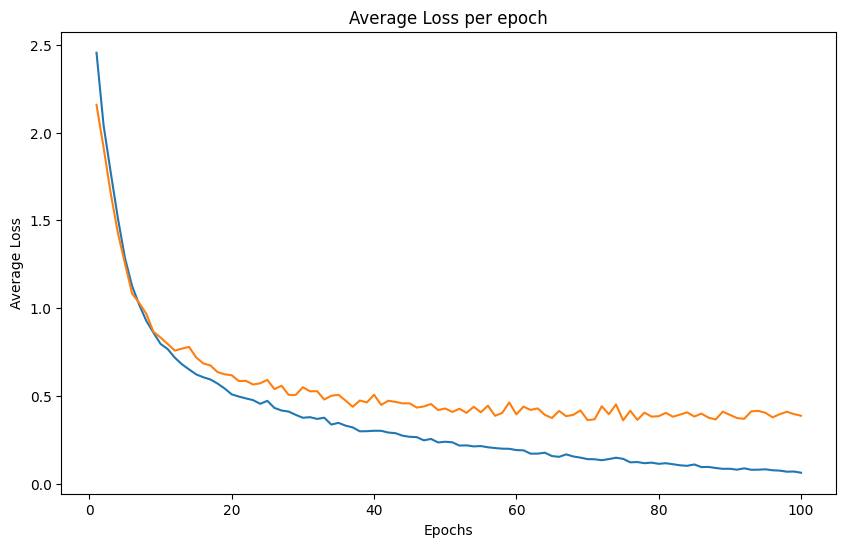

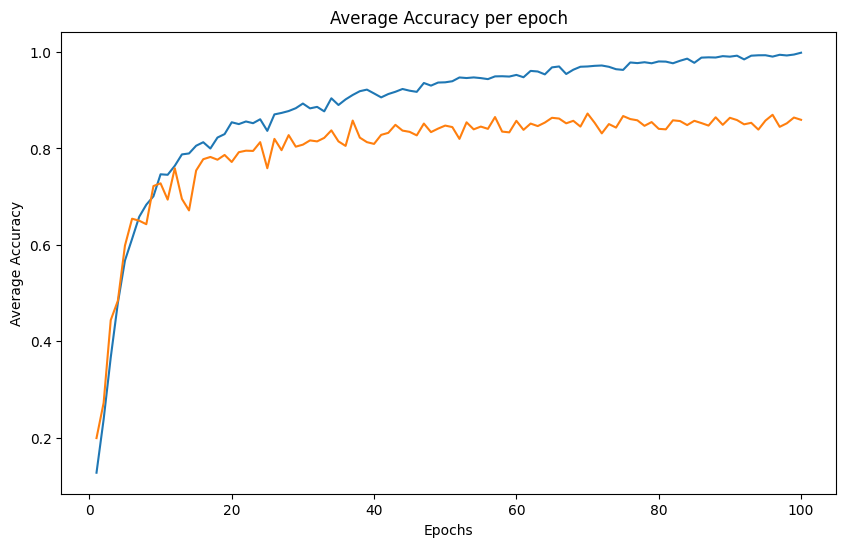

Overall Accuracy: 0.873


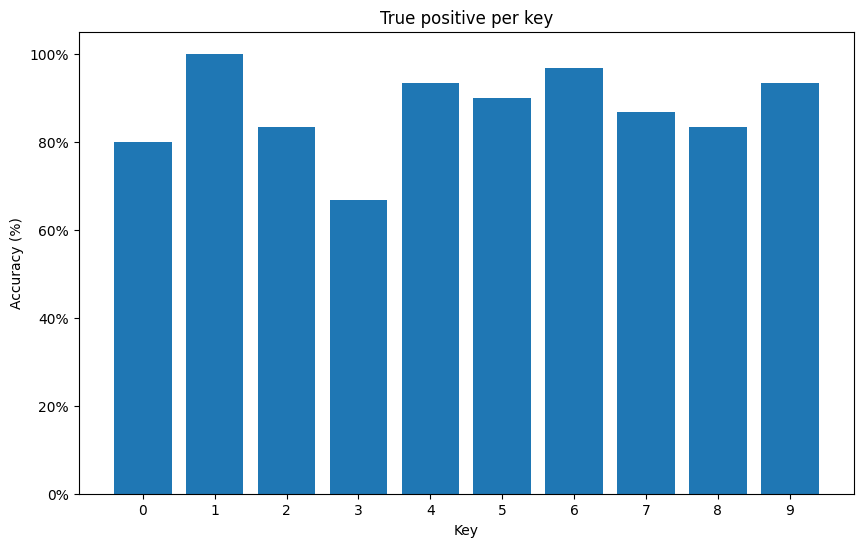

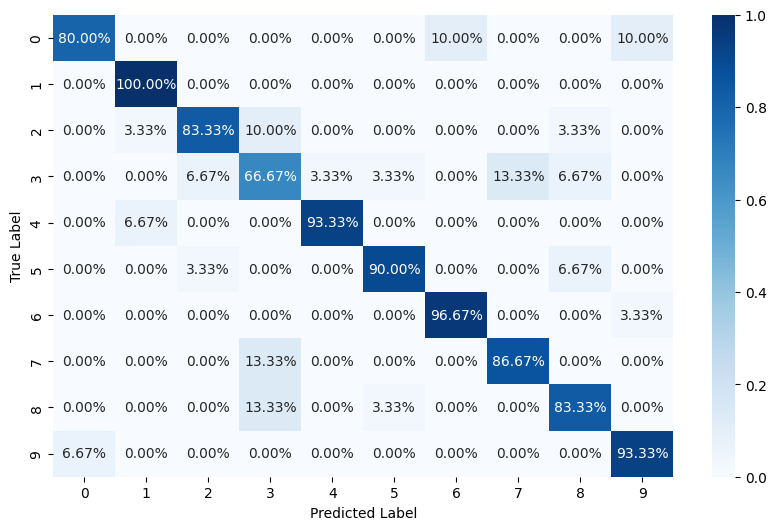

Accuracy for each key: 0: 80.0% 1: 100.0% 2: 83.333% 3: 66.667% 4: 93.333% 5: 90.0% 6: 96.667% 7: 86.667% 8: 83.333% 9: 93.333% 
              precision    recall  f1-score   support

           0       0.92      0.80      0.86        30
           1       0.91      1.00      0.95        30
           2       0.89      0.83      0.86        30
           3       0.65      0.67      0.66        30
           4       0.97      0.93      0.95        30
           5       0.93      0.90      0.92        30
           6       0.91      0.97      0.94        30
           7       0.87      0.87      0.87        30
           8       0.83      0.83      0.83        30
           9       0.88      0.93      0.90        30

    accuracy                           0.87       300
   macro avg       0.87      0.87      0.87       300
weighted avg       0.87      0.87      0.87       300

                    Model Parameters                    
Layer                    | Parameters
conv1d.weight    

In [171]:
def main():
    # setup parameters and load data
    batch_size = 64
    epochs = 100
    number_of_categories = 10
    
    X_train, X_val, X_test, y_train, y_val, y_test = importData()
    trainDataset = CSIDataset(X_train, y_train)
    valDataset = CSIDataset(X_val, y_val)
    
    trainLoader = DataLoader(trainDataset, shuffle=True, batch_size=batch_size)
    valLoader = DataLoader(valDataset, shuffle=True, batch_size=batch_size)

    model = CNN1D(number_of_categories)
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    loss = nn.CrossEntropyLoss()

    if (os.path.isfile("model.pth")):
        model.load_state_dict(torch.load('model.pth'))
    else:
        train_loss_list, train_acc_list, eval_loss_list, eval_acc_list = train_and_eval(model, epochs, optimizer, trainLoader, valLoader, loss, (X_train.shape[0]//batch_size) + 1)
        # save the model
        torch.save(model.state_dict(), 'model.pth')
        plot_loss_accuracy(train_loss_list, train_acc_list, eval_loss_list, eval_acc_list, epochs)
        
    # train_loss_list, train_acc_list, eval_loss_list, eval_acc_list = train_and_eval(model, epochs, optimizer, trainLoader, valLoader, loss, (X_train.shape[0]//batch_size) + 1)
    # plot_loss_accuracy(train_loss_list, train_acc_list, eval_loss_list, eval_acc_list, epochs)
        
    # Simple check with test dataset
    model.eval()
    testDataset = CSIDataset(X_test, y_test)
    testLoader = DataLoader(testDataset, shuffle=True, batch_size=X_test.shape[0])
    test(model, testLoader, X_test.shape[0])
    
    print_model_parameters(model)
    
main()

(3000, 64, 40)
(3000, 2560)
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.006s...
[t-SNE] Computed neighbors for 3000 samples in 0.596s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 65.515120
[t-SNE] KL divergence after 250 iterations with early exaggeration: 4.131577
[t-SNE] KL divergence after 1000 iterations: 3.660566


[Text(0.5, 1.0, 'Amplitude data T-SNE projection')]

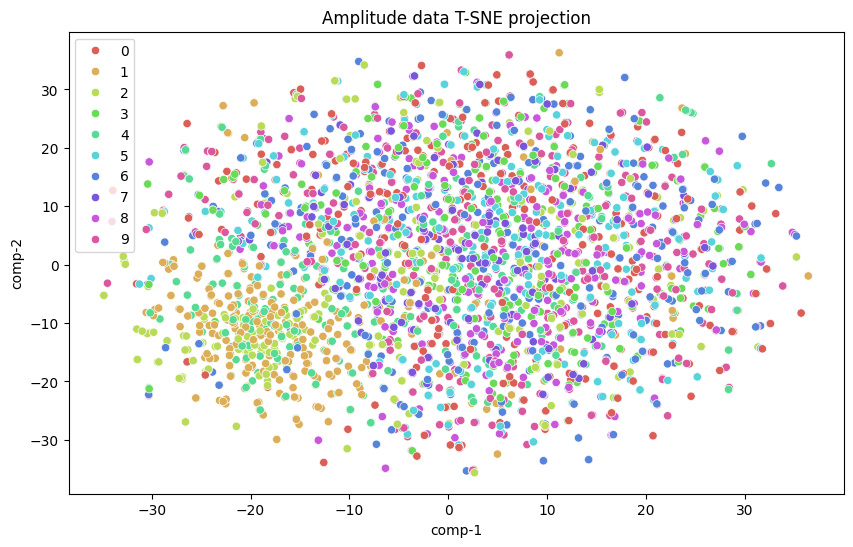

In [166]:
X_train, X_val, X_test, y_train, y_val, y_test = importData()

# stack all the samples together
X_train = np.append(X_train, X_val, axis=0)
y_train = np.append(y_train, y_val, axis=0)

X_train = np.append(X_train, X_test, axis=0)
y_train = np.append(y_train, y_test, axis=0)

X_train, y_train = shuffle(X_train, y_train)
tsne = TSNE(n_components=2, verbose=1, random_state=123, perplexity=10, learning_rate=10, early_exaggeration=1)
print(X_train.shape)
X_train = np.reshape(X_train, [X_train.shape[0], X_train.shape[1]*X_train.shape[2]])
print(X_train.shape)

z = tsne.fit_transform(X_train)

df = pd.DataFrame()
y_train = y_train.flatten()
df["y"] = y_train.tolist()
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x="comp-1", y="comp-2", hue=df.y.tolist(), palette=sns.color_palette("hls", 10)).set(title="Amplitude data T-SNE projection")